In [1]:
!pip uninstall -y torch torchvision torchaudio


!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.41.0

!wget https://github.com/state-spaces/mamba/releases/download/v2.2.2/mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install causal-conv1d>=1.4.0

import torch
print("PyTorch:", torch.__version__)  # e.g., 2.1.0+cu121
print("CUDA:", torch.version.cuda)    # e.g., 12.1
!python --version   

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from mamba_ssm.models.mixer_seq_simple import MixerModel
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from transformers import AutoModelForCausalLM
from mamba_ssm.models.config_mamba import MambaConfig

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 2.0 MB/s eta 0:00:00:00:01m00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 67.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.7 MB/s eta 0:00:00:00:01

✅ Original Data:
📐 Shape: (602962, 9)
🧾 Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Company']

🔍 Sample Data:
                        Date        Open        High         Low       Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000       0.00           0.0    AAPL  
1   28123200       0.00           0.0    MSFT  
2   31004000       0.00           0.0   GOOGL  
3  132264000       0.00           0.0    AMZN  
4   54917200       0.04           0.0    NVDA  


/tmp/ipykernel_35/511293403.py:19: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


AAPL Stock Data Shape before: (1258, 8)
Dataset sizes:
Training: 877 sequences
Validation: 187 sequences
Testing: 189 sequences
torch.Size([16, 5, 5])


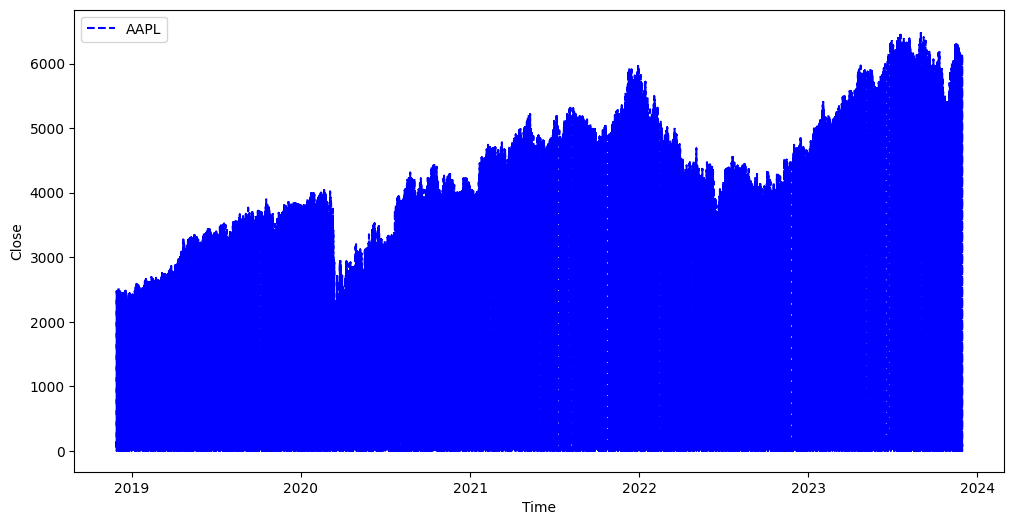

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pylab as plt
df = pd.read_csv('/kaggle/input/yahoofi/stock_details_5_years.csv')
    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

aapl_df = df[df['Company'] == 'AAPL'].copy()
aapl_df.set_index('Date', inplace=True)  # Set date as index for time-based operations
print(f"AAPL Stock Data Shape before: {aapl_df.shape}")
#print(aapl_df.head())
df.describe()


# Select features and target
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
target_col = 'Close'

features = aapl_df[feature_cols].values.astype(np.float32)
target = aapl_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 5
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break
plt.figure(figsize=(12, 6))
plt.plot(df['Date'],df['Close'],'--b',label="AAPL")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close')
plt.show()

In [3]:
import torch
import torch.nn as nn

class Add_Norm(nn.Module):
    def __init__(self, d_model, dropout, residual=True):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.residual = residual
    
    def forward(self, new, old):
        if self.residual:
            return self.norm(old + self.dropout(new))
        return self.norm(self.dropout(new))

class BimambaEncoderLayer(nn.Module):
    def __init__(self, d_model, d_conv, d_state, expand, 
                 b_d_conv, b_d_state, b_expand, dropout, d_ff, 
                 activation="relu", residual=True):
        super().__init__()
        # Mamba blocks (assumed defined elsewhere)
        self.mamba_forward = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        )
        self.mamba_backward = Mamba(
            d_model=d_model, d_state=b_d_state, d_conv=b_d_conv, expand=b_expand
        )
        # Normalization (pre-norm)
        self.norm = nn.LayerNorm(d_model)
        # Add/Norm layers
        self.addnorm1 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm2 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm3 = Add_Norm(d_model, dropout, residual=residual)
        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.addnorm4 = Add_Norm(d_model, dropout, residual=residual)

    def forward(self, x, mask=None):
        x_norm = self.norm(x)
        
        # Forward Mamba block
        out_fwd = self.mamba_forward(x_norm)
        out_fwd = self.addnorm1(out_fwd, x)  # residual=False
        
        # Backward Mamba block
        rev_input = x_norm.flip(dims=[1])
        # rev_mask = mask.flip(dims=[1]) if mask is not None else None  # Not used because Mamba lacks mask support
        
        out_bwd = self.mamba_backward(rev_input)  # no mask passed
        out_bwd = out_bwd.flip(dims=[1])
        out_bwd = self.addnorm2(out_bwd, x)  # residual=False
        
        # Combine forward and backward outputs
        out = out_fwd + out_bwd
        out = self.addnorm3(out, x)  # residual=True
        
        # Feed Forward Network
        ffn_out = self.ffn(out)
        return self.addnorm4(ffn_out, out)  # residual=True

class StockMambaEncoder(nn.Module):
    def __init__(self, input_features=5, d_model=64, n_layer=2, 
                 d_conv=2, d_state=16, expand=2, 
                 b_d_conv=2, b_d_state=16, b_expand=2,
                 dropout=0.1, d_ff=512):
        super().__init__()
        # Input projection
        self.input_proj = nn.Linear(input_features, d_model)
        # Encoder layers
        self.layers = nn.ModuleList([
            BimambaEncoderLayer(
                d_model=d_model, d_conv=d_conv, d_state=d_state, expand=expand,
                b_d_conv=b_d_conv, b_d_state=b_d_state, b_expand=b_expand,
                dropout=dropout, d_ff=d_ff
            ) for _ in range(n_layer)
        ])
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        #print(x.shape)
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)  # mask is accepted but not used for now
        return x


In [8]:
import math
import torch
import torch.nn as nn


class StockMambaDecoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        d_conv,
        d_state,
        expand,
        dropout,
        d_ff,
        activation="relu"  # Added activation parameter
    ):
        super().__init__()
        
        # Causal Mamba layer with residual connection
        self.causal_mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        #cross-mamba
        self.cross_mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        # Improved FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, target, encoder_output, src_mask=None):
       # 1. Process target sequence with causal Mamba
        residual_target = target
        target = self.norm1(target)
        target = self.causal_mamba(target)
        target = residual_target + self.dropout1(target)
        
        # 2. Combine with encoder output (concatenate along sequence dimension)
        combined = torch.cat([encoder_output, target], dim=1)
        
        # 3. Process combined sequence with cross Mamba
        residual_combined = combined
        combined = self.norm2(combined)
        combined = self.cross_mamba(combined)
        combined = residual_combined + self.dropout2(combined)
        
        # 4. Extract the target part (last part of the sequence)
        # Assuming encoder_output has length L, target has length T
        # Combined shape: [batch, L+T, d_model]
        target_output = combined[:, encoder_output.size(1):, :]
        
        # 5. FFN block
        residual_target = target_output
        target_output = self.norm3(target_output)
        target_output = residual_target + self.dropout3(self.ffn(target_output))
        
        return target_output

class StockMambaDecoder(nn.Module):
    def __init__(self,
                 d_model=64,
                 d_conv=2,
                 d_state=16,
                 expand=2,
                 n_layer=2,
                 dropout=0.1,
                 d_ff=256,
                 input_dim=1,
                 output_dim=1,
                 pred_length=1):  # Added prediction length
        super().__init__()
        self.pred_length = pred_length
        
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # Decoder layers
        self.layers = nn.ModuleList([
            StockMambaDecoderLayer(
                d_model=d_model,
                d_conv=d_conv,
                d_state=d_state,
                expand=expand,
                dropout=dropout,
                d_ff=d_ff,
                activation="relu"
            ) for _ in range(n_layer)
        ])
        
        # Multi-step output projection
        self.output_proj = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, output_dim),  # Predict all steps at once
        )
        
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=nn.init.calculate_gain('relu'))

    def forward(self, target, encoder_output, tgt_mask=None, src_mask=None):
        # 1. Project input
        x = self.input_proj(target)
        

        # 2. Zero out padding positions (masked tokens) in decoder input
        if tgt_mask is not None:
            x = x.masked_fill(tgt_mask.unsqueeze(-1), 0.0)


        # 3. Decoder layers
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask=src_mask)

        # 4. Output projection to predict all steps at once
        predictions = self.output_proj(x) 
        
        #predictions = predictions[:, -self.pred_length:, :]
        return predictions.squeeze(-1)


Epoch 1/20: 100%|██████████| 12/12 [00:00<00:00, 124.24it/s]


Epoch 1: Train Loss=1.4788, Val Loss=0.3997, Val RMSE=0.6316
-> Saved Best Model


Epoch 2/20: 100%|██████████| 12/12 [00:00<00:00, 123.56it/s]


Epoch 2: Train Loss=0.2288, Val Loss=0.4469, Val RMSE=0.6722


Epoch 3/20: 100%|██████████| 12/12 [00:00<00:00, 126.05it/s]


Epoch 3: Train Loss=0.1790, Val Loss=0.1721, Val RMSE=0.4163
-> Saved Best Model


Epoch 4/20: 100%|██████████| 12/12 [00:00<00:00, 123.63it/s]


Epoch 4: Train Loss=0.1394, Val Loss=0.0669, Val RMSE=0.2594
-> Saved Best Model


Epoch 5/20: 100%|██████████| 12/12 [00:00<00:00, 128.61it/s]


Epoch 5: Train Loss=0.0840, Val Loss=0.0715, Val RMSE=0.2691


Epoch 6/20: 100%|██████████| 12/12 [00:00<00:00, 127.11it/s]


Epoch 6: Train Loss=0.0754, Val Loss=0.0294, Val RMSE=0.1709
-> Saved Best Model


Epoch 7/20: 100%|██████████| 12/12 [00:00<00:00, 128.01it/s]


Epoch 7: Train Loss=0.0434, Val Loss=0.0346, Val RMSE=0.1870


Epoch 8/20: 100%|██████████| 12/12 [00:00<00:00, 124.03it/s]


Epoch 8: Train Loss=0.0359, Val Loss=0.0840, Val RMSE=0.2902


Epoch 9/20: 100%|██████████| 12/12 [00:00<00:00, 126.06it/s]


Epoch 9: Train Loss=0.0336, Val Loss=0.0295, Val RMSE=0.1723


Epoch 10/20: 100%|██████████| 12/12 [00:00<00:00, 120.00it/s]


Epoch 10: Train Loss=0.0241, Val Loss=0.0101, Val RMSE=0.1007
-> Saved Best Model


Epoch 11/20: 100%|██████████| 12/12 [00:00<00:00, 123.08it/s]


Epoch 11: Train Loss=0.0300, Val Loss=0.0150, Val RMSE=0.1233


Epoch 12/20: 100%|██████████| 12/12 [00:00<00:00, 126.50it/s]


Epoch 12: Train Loss=0.0208, Val Loss=0.0118, Val RMSE=0.1096


Epoch 13/20: 100%|██████████| 12/12 [00:00<00:00, 129.01it/s]


Epoch 13: Train Loss=0.0180, Val Loss=0.0115, Val RMSE=0.1061


Epoch 14/20: 100%|██████████| 12/12 [00:00<00:00, 126.92it/s]


Epoch 14: Train Loss=0.0105, Val Loss=0.0073, Val RMSE=0.0865
-> Saved Best Model


Epoch 15/20: 100%|██████████| 12/12 [00:00<00:00, 123.68it/s]


Epoch 15: Train Loss=0.0092, Val Loss=0.0084, Val RMSE=0.0913


Epoch 16/20: 100%|██████████| 12/12 [00:00<00:00, 126.66it/s]


Epoch 16: Train Loss=0.0077, Val Loss=0.0066, Val RMSE=0.0822
-> Saved Best Model


Epoch 17/20: 100%|██████████| 12/12 [00:00<00:00, 128.93it/s]


Epoch 17: Train Loss=0.0068, Val Loss=0.0058, Val RMSE=0.0767
-> Saved Best Model


Epoch 18/20: 100%|██████████| 12/12 [00:00<00:00, 126.10it/s]


Epoch 18: Train Loss=0.0048, Val Loss=0.0060, Val RMSE=0.0781


Epoch 19/20: 100%|██████████| 12/12 [00:00<00:00, 125.07it/s]


Epoch 19: Train Loss=0.0070, Val Loss=0.0102, Val RMSE=0.1008


Epoch 20/20: 100%|██████████| 12/12 [00:00<00:00, 125.95it/s]


Epoch 20: Train Loss=0.0052, Val Loss=0.0088, Val RMSE=0.0941


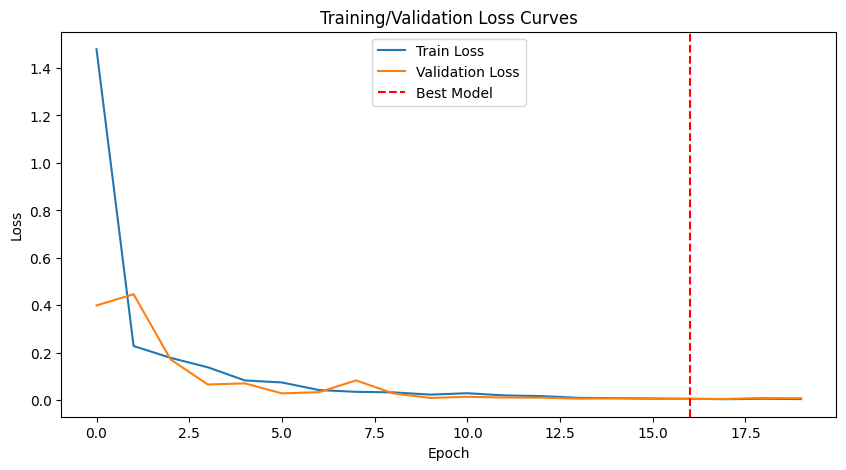

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced Loss Function
class StockLoss(nn.Module):
    def __init__(self, delta=0.5, direction_weight=0.6, margin=0.02):
        super().__init__()
        self.huber = nn.HuberLoss(delta=delta)
        self.direction_weight = direction_weight
        self.margin = margin
        
    def forward(self, preds, targets):
        # Base regression loss
        huber_loss = self.huber(preds, targets)
        
        # Directional loss only for multi-step predictions
        if preds.size(1) > 1:
            pred_dirs = preds[:, 1:] - preds[:, :-1]
            true_dirs = targets[:, 1:] - targets[:, :-1]
            
            # Only consider significant movements
            significant_moves = (true_dirs.abs() > self.margin).float()
            dir_accuracy = torch.sign(pred_dirs * true_dirs)
            
            # Loss for wrong directions on significant moves
            dir_loss = torch.mean(torch.relu(-dir_accuracy * significant_moves))
        else:
            dir_loss = torch.tensor(0.0, device=preds.device)
            
        return huber_loss + self.direction_weight * dir_loss

# Initialize your existing encoder (unchanged)
encoder = StockMambaEncoder(input_features=5, d_model=64)
decoder = StockMambaDecoder(pred_length=PRED_LENGTH)
model = nn.ModuleDict({'encoder': encoder, 'decoder': decoder}).to(device)

# Stronger regularization in optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)  # Increased weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = nn.MSELoss()

best_val_loss = float('inf')
no_improve = 0
patience = 7
train_losses = []
val_losses = []
epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    epoch_train_losses = []
    
    # Data augmentation with Gaussian noise
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        enc_out = model['encoder'](batch_X)
        
        decoder_input = torch.cat([
        batch_X[:, -1:, 3:4],  # Last encoder timestep
        batch_y[:, :-1, :]    # Shifted targets (exclude last)
        ], dim=1)
        
        preds = model['decoder'](decoder_input, enc_out)
        loss = criterion(preds, batch_y.squeeze(-1))
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Tighter clipping
        optimizer.step()
        
        epoch_train_losses.append(loss.item())


    
    # Validation
    losses = []
    all_preds = []
    all_targets = []
    for batch_X, batch_y in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        enc_out = model['encoder'](batch_X)

        decoder_input = torch.cat([
        batch_X[:, -1:, 3:4],  # Last encoder timestep
        batch_y[:, :-1, :]    # Shifted targets (exclude last)
        ], dim=1)
        preds = model['decoder'](decoder_input, enc_out)
        all_preds.append(preds.squeeze(1).detach().cpu().numpy())
        all_targets.append(batch_y.squeeze(-1).detach().cpu().numpy())
        loss = criterion(preds, batch_y.squeeze(-1))
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_loss=avg_loss
    val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    scheduler.step(val_loss)
    
    # Track losses
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={val_loss:.4f}, Val RMSE={val_rmse:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_mamba_stock.pth")
        print("-> Saved Best Model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# Plot learning curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(np.argmin(val_losses), color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss Curves')
plt.show()


Testing:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([13, 1, 1])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
Testing: 100%|██████████| 12/12 [00:00<00:00, 139.92it/s]


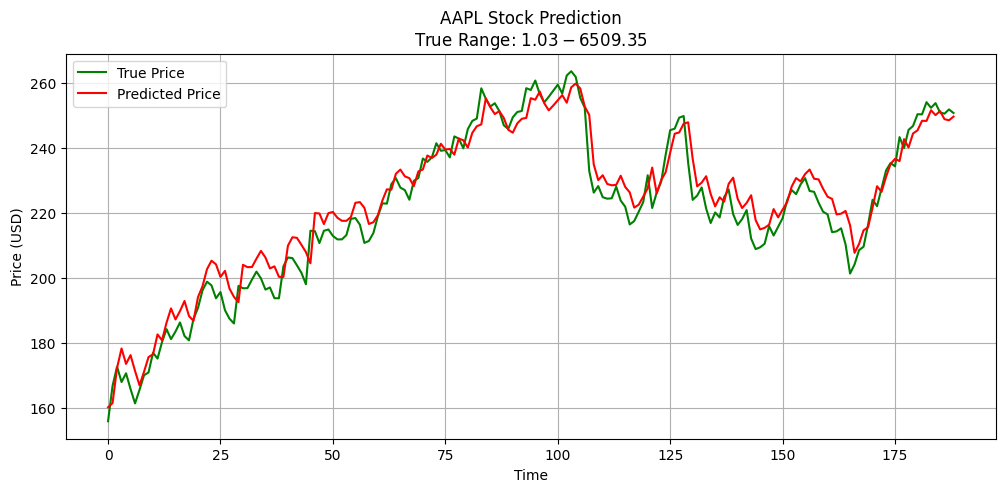


Normalized Metrics:
Test Loss: 0.0062
RMSE: 0.0586
MAE: 0.0471
R²: 0.9425
MAPE: 4.26%

Denormalized Metrics (USD):
RMSE: $5.86
MAE: $4.71
MAPE: 2.21%


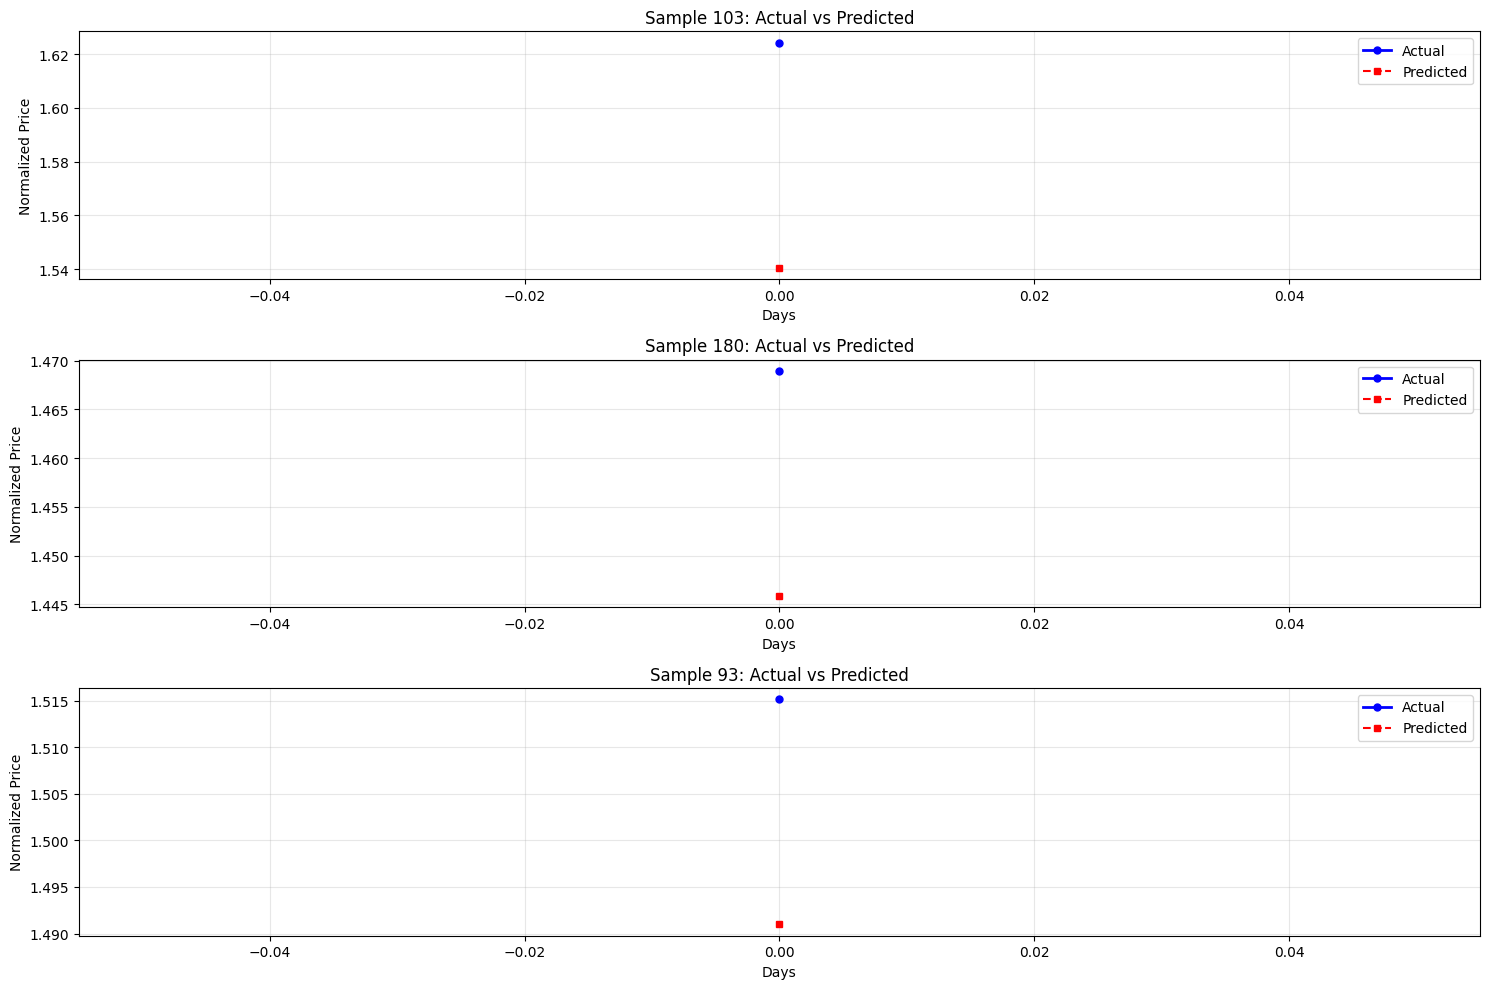

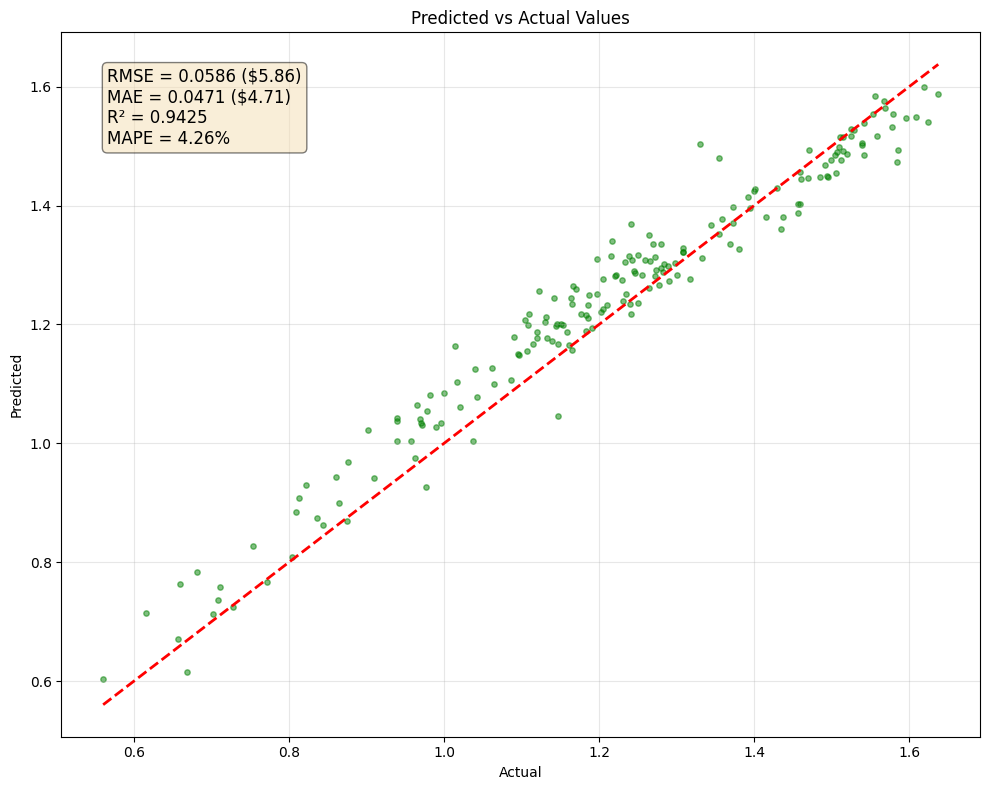

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


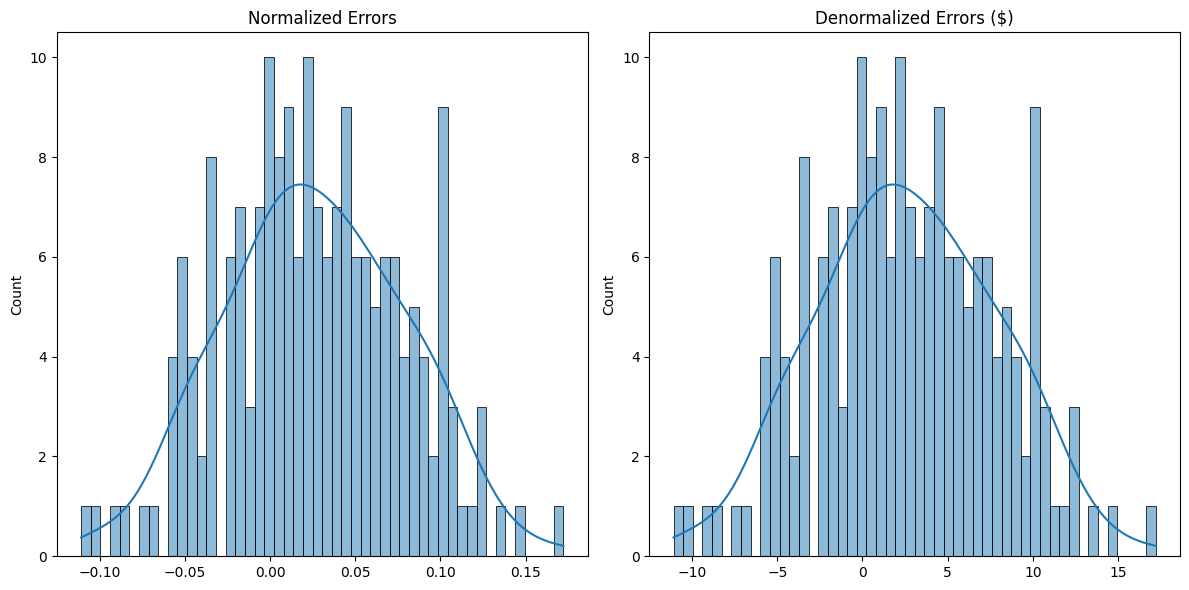

In [23]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import torch

# Assuming you have your scaler object saved during training
# If not, you'll need to recreate it with the original data range
# Example for MinMaxScaler (adjust if you used StandardScaler):
# scaler = MinMaxScaler()
# scaler.min_, scaler.scale_ = your_saved_min, your_saved_scale

# Define the loss function
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02)

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth
all_predictions = []
all_ground_truth = []

# Initialize total test loss
total_test_loss = 0

# Disable gradient calculation
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Testing")):
        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Extract the last closing price from input sequence
        last_closing = x_batch[:, -1, 3]  # Shape: [batch_size]
        
        # Create decoder input
        decoder_input = torch.zeros(x_batch.size(0), PRED_LENGTH, 1, device=device)
        decoder_input[:, 0, 0] = last_closing  # Set first time step's feature
        
        # Forward pass
        encoder_output = model['encoder'](x_batch)
        predictions= model['decoder'](decoder_input, encoder_output)
        
        # Calculate loss
        loss = criterion(predictions, y_batch)
        total_test_loss += loss.item() * x_batch.size(0)
        
        # Store predictions and ground truth
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truth.append(y_batch.cpu().numpy())

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_loader.dataset)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)

# Flatten for metrics calculation
y_true = all_ground_truth.flatten()
y_pred = all_predictions.flatten()

# Calculate metrics with error handling
try:
    # Normalized metrics
    # Calculate metrics with proper parenthesis balancing
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

    # Denormalization example (replace with your actual scaler values)
    data_min = 100.0  # Minimum price in dataset
    data_max = 200.0  # Maximum price in dataset

    y_true_denorm = y_true * (data_max - data_min) + data_min
    y_pred_denorm = y_pred * (data_max - data_min) + data_min

    # Denormalized metrics
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mape_denorm = np.mean(np.abs((y_true_denorm - y_pred_denorm) / np.maximum(np.abs(y_true_denorm), 1e-8))) * 100
    
    # Plotting with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAPL Stock Prediction\nTrue Range: ${df['Close'].min():.2f}-${df['Close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"\nNormalized Metrics:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f}")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE: {mape_denorm:.2f}%")

except Exception as e:
    print(f"Error calculating metrics: {str(e)}")

# Visualization
try:
    # Plot 1: Time-series comparison
    plt.figure(figsize=(15, 10))
    for i in range(3):
        idx = np.random.randint(0, len(all_predictions))
        plt.subplot(3, 1, i+1)
        plt.plot(all_ground_truth[idx], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(all_predictions[idx], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {idx+1}: Actual vs Predicted")
        plt.xlabel("Days")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.savefig('time_series_comparison.png', dpi=300)
    plt.show()

    # Plot 2: Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
        f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
        f'MAE = {mae:.4f} (${mae_denorm:.2f})',
        f'R² = {r2:.4f}',
        f'MAPE = {mape:.2f}%'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show()

    # Plot 3: Error distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error generating plots: {str(e)}")